- 손으로 쓴 숫자 글씨 데이터셋인 MINST
- deeplearning.net이 제공하는 피클 버전을 사용
- 훈련셋 50000건, 검증셋 10000건, 테스트셋 10000건의 예제를 포함하며, 모든 예제에 레이블이 부여되어 있다. 

In [1]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
download_root = 'MNIST_data/'

In [3]:
# loading
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
#shape of dataset
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [5]:
X_validation = X_train[50000:]
y_validation = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_validation: ' + str(X_validation.shape))
print('Y_validation: ' + str(y_validation.shape))

X_train: (50000, 28, 28)
Y_train: (50000,)
X_validation: (10000, 28, 28)
Y_validation: (10000,)


In [6]:
X_train = X_train.reshape(-1,28*28)
X_validation = X_validation.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

print('X_train: ' + str(X_train.shape))
print('X_validation: ' + str(X_validation.shape))
print('X_test: ' + str(X_test.shape))

X_train: (50000, 784)
X_validation: (10000, 784)
X_test: (10000, 784)


In [7]:
# 데이터셋으로부터 pandas data frame 생성
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data = X_train, index = train_index)
y_train = pd.Series(data = y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

- 클러스터링을 수행하기 전에 PCA를 사용해 데이터 차원을 줄인다.

In [8]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state=2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

- n_jobs는 버전이 업데이트 되면서 사라짐

### k-평균 관성
- 각 관측치와 군집의 중심점 또는 중심 간 유클리드 거리를 최소화하도록 관측치를 다른 군집에 재할당한다.

In [9]:
# k-평균 - 군집 수 변화에 따른 관성
from sklearn.cluster import KMeans

n_clusters = 10 # 군집의 수
n_init = 10 # 초기화 횟수
max_iter = 300 # 최대 반복 횟수
tol = 0.0001 # 수렴 허용 오차
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[], index=range(2,21), columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
                   tol=tol, random_state=random_state)
    cutoff = 99 # 주성분 100개 사용
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

<AxesSubplot:>

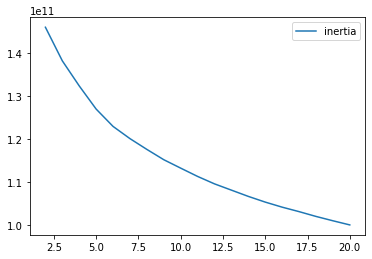

In [10]:
kMeans_inertia.plot()

- 군집 수가 증가함에 따라 관성(군집 내 분산)이 감소 -> 군집이 많을수록 각 군집 내 관측치 간 동질성이 커진다는 의미

#### 클러스터링 결과 평가하기

In [15]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True, drop=False)
    countByCluster.columns = ['cluster', 'clusterCount']
    
    preds = pd.concat([labelsDF, clusterDF], axis=1)
    preds.columns = ['trueLabel', 'cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0])) # 가장 자주 발생하는 숫자의 개수
    countMostFreq.reset_index(inplace=True, drop=False)
    countMostFreq.columns = ['cluster', 'countMostFrequent']
    
    # 군집의 전체 정확도
    accuracyDF = countMostFreq.merge(countByCluster, left_on="cluster", right_on = "cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    # 모든 군집별로 가장 자주 발생하는 관측치 개수 합을 훈련셋의 총 관측치 개수로 나눈 값
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [17]:
# K-평균 - 군집 수에 따른 정확도

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[], index=range(2,21), columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=range(2,21), columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters = n_clusters, n_init = n_init, max_iter = max_iter, tol=tol, random_state=random_state)
    cutoff=99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans,\
    accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<AxesSubplot:>

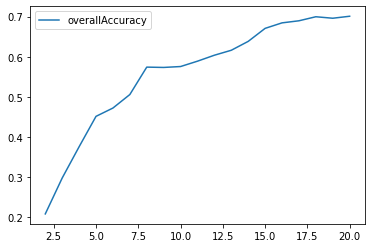

In [19]:
overallAccuracy_kMeansDF.plot()

In [20]:
accuracyByLabel_kMeans

0     0.928172
1     0.849176
2     0.874955
3     0.455545
4     0.592881
5     0.385702
6     0.932873
7     0.721638
8     0.495248
9     0.847841
10    0.891425
11    0.636328
12    0.916874
13    0.956971
14    0.942112
15    0.379933
16    0.464061
17    0.793194
18    0.528749
19    0.949918
dtype: float64

- 클러스터 수가 증가함에 따라 정확도가 향상, 클러스터가 더욱 동질해짐

In [32]:
# K-평균 - 주성분 수에 따른 정확도

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

<AxesSubplot:>

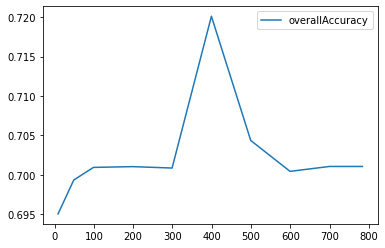

In [33]:
overallAccuracy_kMeansDF.plot()

- 군집 정확도는 안정적이고 일관되게 약 70% 유지 -> 차원 축소된 데이터셋에서 클러스터링을 수행해야 하는 이유

In [39]:
# k-평균 - 주성분 수 변화에 따른 정확도
# 원본 MNIST 데이터셋(PCA로 축소되지 않은)

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[], index=[9,49,99,199,299,399,499,599,699,784], columns=['overallAccuracy'])

for cutoffNumber in [9,49,99,199,299,399,499,599,699,784]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter = max_iter, tol=tol, random_state = random_state)
    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans,
    accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

C:\Users\82109\AppData\Local\Temp/ipykernel_13188/1480253582.py:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans.fit(X_train.loc[:,0:cutoff])


<AxesSubplot:>

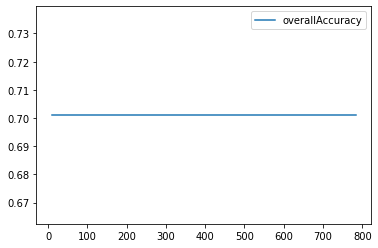

In [40]:
overallAccuracy_kMeansDF.plot()